<a href="https://colab.research.google.com/github/fjgr/IA_BigData/blob/main/SNS/Act_3_4/SNS_ACT3_4_Representaci%C3%B3n_plot_de_datasets%2C_selecci%C3%B3n_de_caracter%C3%ADsticas_y_entrenamiento_de_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Descripción del Dataset

El dataset **CICIDS2017** está diseñado para tareas de investigación en ciberseguridad y clasificación de tráfico de red. Fue creado por el Canadian Institute for Cybersecurity y contiene datos generados en un entorno controlado que simula escenarios reales de tráfico de red, incluyendo tanto tráfico benigno como malicioso (ataques como DDoS, fuerza bruta, infiltraciones, entre otros).

Cada archivo representa un día o tipo de tráfico y contiene las siguientes características principales:

**Flow Duration:** Duración del flujo de red en milisegundos.

**Total Fwd Packets:** Número total de paquetes enviados hacia adelante.

**Total Backward Packets:** Número total de paquetes enviados hacia atrás.

**Flow Bytes/s:** Tasa de bytes transferidos por segundo en el flujo.

**Fwd Packet Length Mean:** Longitud media de los paquetes enviados hacia adelante.

**Backward Packet Length Mean:** Longitud media de los paquetes enviados hacia atrás.

**Label:** Clase objetivo, que indica si el tráfico es benigno o malicioso, y el tipo de ataque si es malicioso.

In [ ]:
import os
import pandas as pd
import kagglehub

# Descargar el dataset
path = kagglehub.dataset_download("dhoogla/cicids2017")

# Listar archivos en el directorio del dataset
print("Archivos en la carpeta descargada:")
files_in_path = os.listdir(path)
print(files_in_path)

100%|███████████████████████████████████████| 227M/227M [00:07<00:00, 33.4MB/s]

Extracting files...


Archivos en la carpeta descargada:
['Benign-Monday-no-metadata.parquet', 'Botnet-Friday-no-metadata.parquet', 'Bruteforce-Tuesday-no-metadata.parquet', 'DDoS-Friday-no-metadata.parquet', 'DoS-Wednesday-no-metadata.parquet', 'Infiltration-Thursday-no-metadata.parquet', 'Portscan-Friday-no-metadata.parquet', 'WebAttacks-Thursday-no-metadata.parquet']


# 2. Procesamiento de Datos
El procesamiento inicial implica:

**2.1. Carga de los datos**

Se cargan los archivos Parquet y se combinan en un único DataFrame:

In [ ]:
# Combinar archivos Parquet
files = [os.path.join(path, f) for f in files_in_path if f.endswith('.parquet')]
dataframes = [pd.read_parquet(file) for file in files]
data = pd.concat(dataframes, ignore_index=True)

**2.2. Limpieza de datos**

* Manejo de valores faltantes:

In [ ]:
# Eliminar filas con valores nulos
cleaned_data = data.dropna()

* Conversión de variables categóricas:

In [ ]:
# Asegurar que 'Label' sea categórico
cleaned_data['Label'] = cleaned_data['Label'].astype('category')

* División en características y etiquetas:

In [ ]:
X = cleaned_data.drop(columns=['Label'])
y = cleaned_data['Label']

# 3. Selección de Características

**3.1. Matriz de correlación**

La matriz de correlación ayuda a identificar relaciones entre las características numéricas.

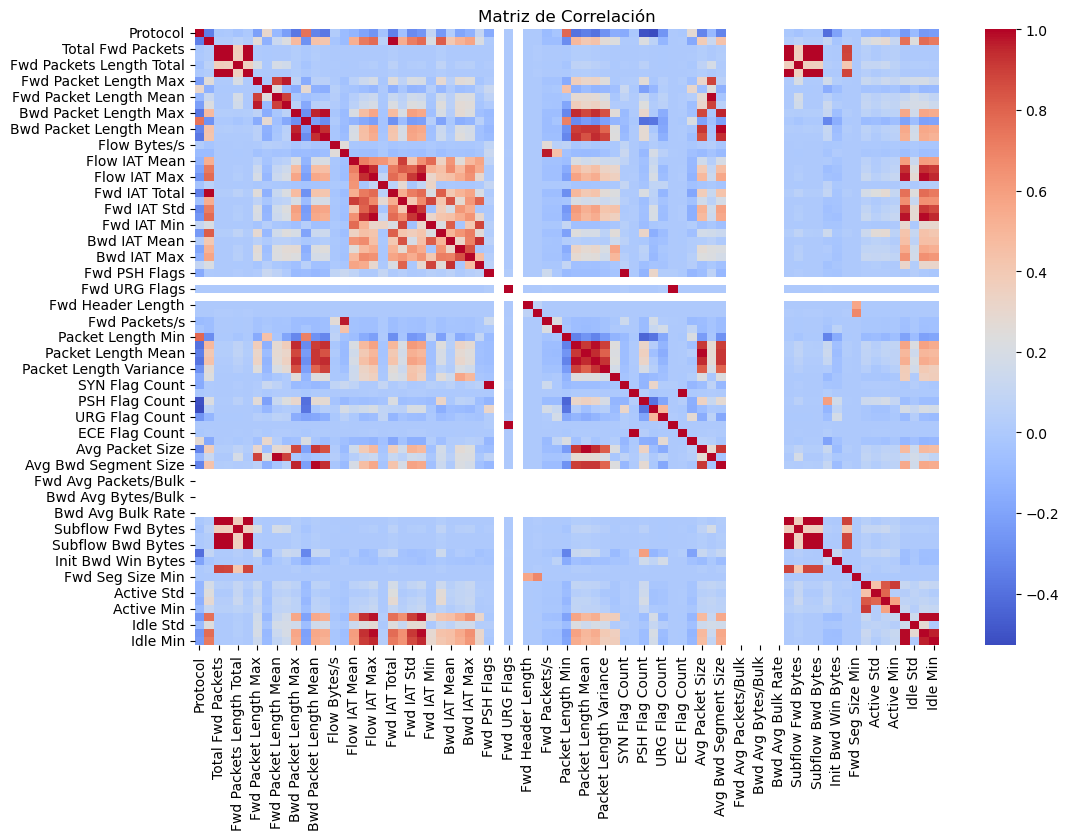

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
correlation_matrix = X.corr()

# Visualizar
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

**3.2. Matriz de dispersión**

Ayuda a visualizar relaciones entre pares de características y su influencia en la clase objetivo.

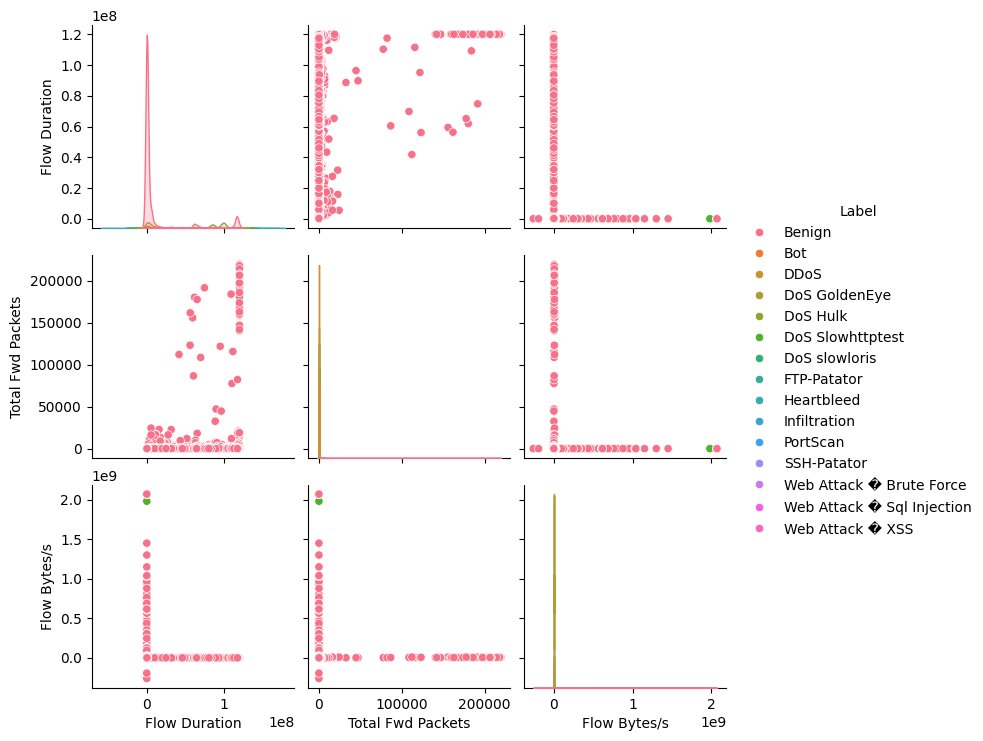

In [ ]:
# Seleccionar algunas características para visualizar
selected_columns = ['Flow Duration', 'Total Fwd Packets', 'Flow Bytes/s']
sns.pairplot(cleaned_data[selected_columns + ['Label']], hue='Label')
plt.show()

**3.3. SelectKBest**

Permite seleccionar las características más relevantes en función de una métrica estadística.

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

# Normalizar los datos para chi2
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Selección de las mejores k características
k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]
print("Características seleccionadas:", selected_features)

Características seleccionadas: Index(['Bwd Packet Length Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Std',
       'Fwd IAT Max', 'Packet Length Std', 'FIN Flag Count', 'Idle Mean',
       'Idle Max', 'Idle Min'],
      dtype='object')


# 4. Reflexión sobre las características

Las características seleccionadas a menudo incluyen métricas clave como duración del flujo, número de paquetes y tasas de bytes por segundo, que son indicadores claros de patrones de tráfico. Estas características permiten diferenciar eficientemente entre tráfico benigno y malicioso.

# 5. Entrenamiento del Modelo Random Forest

**5.1. Sin Cross Validation**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Entrenamiento con Random Forest
model = RandomForestClassifier(
      n_estimators=229,        # Número de árboles
      max_depth=None,          # Sin límite de profundidad
      min_samples_leaf=2,      # Mínimas muestras en las hojas
      min_samples_split=7,     # Mínimas muestras para dividir
      class_weight='balanced', # Ajuste automático los pesos
      random_state=42          # Reproducibilidad
)
model.fit(X_train, y_train)

# Predicción
y_pred = model.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


Accuracy: 0.8866069383397945

Reporte de clasificación:
                             precision    recall  f1-score   support

                    Benign       1.00      0.87      0.93    395259
                       Bot       0.63      0.78      0.70       290
                      DDoS       0.99      0.99      0.99     25529
             DoS GoldenEye       0.90      0.98      0.94      2052
                  DoS Hulk       0.99      0.96      0.98     34892
          DoS Slowhttptest       0.91      0.99      0.95      1037
             DoS slowloris       0.99      0.98      0.99      1043
               FTP-Patator       0.99      1.00      0.99      1191
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.29      0.44         7
                  PortScan       0.14      0.70      0.23       374
               SSH-Patator       0.98      0.92      0.94       671
  Web Attack � Brute Force       0.75      0.64      0.69 

**5.2. Con Cross Validation**

In [ ]:
from sklearn.model_selection import cross_val_score

# Validación cruzada
scores = cross_val_score(model, X_new, y, cv=5, scoring='f1_macro')

# Resultados
print("Puntajes de Cross Validation:", scores)
print("Media de Accuracy:", scores.mean())
print("Desviación estándar de Accuracy:", scores.std())

Puntajes de Cross Validation: [0.64353302 0.71717146 0.74197709 0.75545688 0.65312745]
Media de Accuracy: 0.7022531812313991
Desviación estándar de Accuracy: 0.04580954472461399


**NOTA:** F1-Score promedio ponderando igualmente todas las clases (útil para multiclase).

# 6. Conclusión

El uso de validación cruzada mejora la evaluación del modelo al garantizar que el rendimiento no esté sesgado por una partición específica de los datos. En contraste, sin validación cruzada, los resultados pueden ser optimistas o pesimistas dependiendo de la división de los datos. Cross Validation proporciona una estimación más robusta del rendimiento general del modelo.

# 7. Herramienta adicional

Implementación de la técnica PCA para reducir dimensionalidad:

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)  # Selecciona un número de componentes que capture la mayor varianza
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print("Varianza explicada por los 10 componentes principales:", pca.explained_variance_ratio_)


Varianza explicada por los 10 componentes principales: [0.34590538 0.22690482 0.15683324 0.065941   0.05151088 0.03213178
 0.02782875 0.02424476 0.01778494 0.0135651 ]
